# Condensate Feature Prediction -- Rotation Project

### Load in data

In [2]:
import os
import random
import pickle
import psutil
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetTemperature, NVML_TEMPERATURE_GPU
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import KFold, LeaveOneGroupOut, GroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import subprocess

/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_2247/3821465238.py:5: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetTemperature, NVML_TEMPERATURE_GPU


In [2]:
small_pl_data = pd.read_csv("/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/data/small_pool_data_with_seq_info_202507.csv", 
                             index_col=False)
list(small_pl_data.columns)
small_pl_data.shape

# large pool data
large_pl_data = pd.read_csv("/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/data/large_pool_data_with_seq_info_202507.csv")
large_pl_data.shape
list(large_pl_data.columns)

# check all are the same length
lengths_sml = [len(small_pl_data["protein_seq"][i]) for i in range(small_pl_data.shape[0])]
set(lengths_sml)



/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_7777/548658485.py:7: DtypeWarning: Columns (6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  large_pl_data = pd.read_csv("/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/data/large_pool_data_with_seq_info_202507.csv")


{66}

## Preprocessing

In [3]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


def read_mmseqs_into_distance(filename):
    df = pd.read_csv(filename, sep="\t", usecols=[0,1,2], names=["query", "target", "identity"])
    seq_ids = pd.unique(df[['query','target']].values.ravel())
    n = len(seq_ids)

    # Map sequence ID to index
    id_to_idx = {seq_id: i for i, seq_id in enumerate(seq_ids)}
    dist_matrix = np.ones((n,n))
    np.fill_diagonal(dist_matrix, 0)
    for _, row in df.iterrows():
        i = id_to_idx[row['query']]
        j = id_to_idx[row['target']]
        dist = 1.0 - row['identity']  # identity should be in [0,1]; divide by 100 if in %
        dist_matrix[i,j] = dist
        dist_matrix[j,i] = dist  # symmetric
    return dist_matrix

def hierarchical_cluster_mmseqs(filename, num_clusters=10, threshold=0.3, method='threshold'):
    if method not in ["threshold", "num_clusters"]: raise ValueError("method should be 'threshold' or 'num_clusters'")
    df = pd.read_csv(filename, sep="\t", usecols=[0,1,2], names=["query", "target", "identity"])
    seq_ids = pd.unique(df[['query','target']].values.ravel())
    dist_matrix = read_mmseqs_into_distance(filename)

    Z = linkage(dist_matrix, method='average')  # or 'single', 'complete', 'ward'
    dendrogram(Z, labels=seq_ids)
    plt.show()

    # Cut tree to get cluster labels    
    if method == "threshold": clusters = fcluster(Z, threshold, criterion='distance')
    elif method == "num_clusters": clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
    return clusters

def one_hot_encode(seq):
    # shape: (length_of_seq, 20)
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

    encoding = np.zeros((len(seq), len(amino_acids)), dtype=np.int8)
    for i, aa in enumerate(seq):
        if aa in aa_to_index:  # skip if non-standard residue
            encoding[i, aa_to_index[aa]] = 1
    return encoding

def kmer_table(seqs, k=3):
    """
    Convert a list of sequences into a k-mer count matrix.    
    Args:
        seqs (list of str): List of sequences (all same alphabet, e.g. DNA/protein).
        k (int): k-mer size.        
    Returns:
        np.ndarray: Matrix of shape (num_seqs, num_unique_kmers).
        list: List of unique kmers in column order.
    """

    # collect all kmers across all seqs
    all_kmers = []
    for seq in seqs:
        for i in range(len(seq) - k + 1):
            all_kmers.append(seq[i:i+k])
    unique_kmers = sorted(set(all_kmers))  # column order

    # mapping for column index
    kmer_index = {kmer: i for i, kmer in enumerate(unique_kmers)}

    # build matrix
    matrix = np.zeros((len(seqs), len(unique_kmers)), dtype=int)
    for row, seq in enumerate(seqs):
        counts = Counter(seq[i:i+k] for i in range(len(seq) - k + 1))
        for kmer, c in counts.items():
            col = kmer_index[kmer]
            matrix[row, col] = c

    return matrix, unique_kmers


In [119]:
# one hot encode protein seq
label_col = "medium_GFP_fraction_cells_with_condensates"

subset_data = large_pl_data[["protein_seq", label_col]]
subset_data = subset_data.dropna(subset=[subset_data.columns[1]])

seq_data = np.array([one_hot_encode(i) for i in subset_data["protein_seq"]])
labels = subset_data["medium_GFP_fraction_cells_with_condensates"]
seq_data.shape

(6994, 66, 20)

In [ ]:
seq_data = torch.tensor(seq_data.reshape(seq_data.shape[0], -1), dtype=torch.float32).to(config.device)


In [288]:
# Create kmer table
# SLiMs are 3-10 aa long

seqs = subset_data["protein_seq"].values
kmer_matrix, unique_kmers = kmer_table(seqs, k=3)
print(kmer_matrix.shape)

# double check this works
kmer_matrix, unique_kmers = kmer_table([seqs[0]])

print({k:int(v) for k,v in zip(unique_kmers, kmer_matrix[0])})
print(dict(sorted(Counter([seqs[0][i:i+3] for i in range(len(seqs[0]) - 3 + 1)]).items(), key=lambda x: x[0])))


(6994, 7696)
{'AAA': 7, 'AAH': 1, 'AAR': 1, 'AAT': 2, 'AAV': 1, 'ADP': 1, 'AHF': 1, 'AMD': 1, 'ANA': 1, 'APL': 1, 'APQ': 1, 'APT': 1, 'ARA': 2, 'ATA': 1, 'ATE': 1, 'AVQ': 1, 'AWA': 1, 'CET': 1, 'DCE': 1, 'DPT': 1, 'EAP': 1, 'ETH': 1, 'FPA': 1, 'FTA': 1, 'HAA': 1, 'HAP': 1, 'HFT': 1, 'HQH': 1, 'HRH': 1, 'LAW': 1, 'MDC': 1, 'NAA': 1, 'PAP': 1, 'PLA': 1, 'PQV': 1, 'PTH': 1, 'PTQ': 1, 'QAM': 1, 'QFP': 1, 'QHR': 1, 'QQF': 1, 'QVR': 1, 'QVT': 1, 'RAD': 1, 'RAR': 1, 'RHA': 1, 'RQQ': 1, 'TAA': 1, 'TAN': 1, 'TEA': 1, 'THA': 1, 'THQ': 1, 'TQV': 1, 'VQA': 1, 'VRQ': 1, 'WAA': 1}
{'AAA': 7, 'AAH': 1, 'AAR': 1, 'AAT': 2, 'AAV': 1, 'ADP': 1, 'AHF': 1, 'AMD': 1, 'ANA': 1, 'APL': 1, 'APQ': 1, 'APT': 1, 'ARA': 2, 'ATA': 1, 'ATE': 1, 'AVQ': 1, 'AWA': 1, 'CET': 1, 'DCE': 1, 'DPT': 1, 'EAP': 1, 'ETH': 1, 'FPA': 1, 'FTA': 1, 'HAA': 1, 'HAP': 1, 'HFT': 1, 'HQH': 1, 'HRH': 1, 'LAW': 1, 'MDC': 1, 'NAA': 1, 'PAP': 1, 'PLA': 1, 'PQV': 1, 'PTH': 1, 'PTQ': 1, 'QAM': 1, 'QFP': 1, 'QHR': 1, 'QQF': 1, 'QVR': 1, 'QVT'

In [ ]:
# Sequence Features
sequence_feature_cols = ['fraction_A',
 'fraction_C',
 'fraction_D',
 'fraction_E',
 'fraction_F',
 'fraction_G',
 'fraction_H',
 'fraction_I',
 'fraction_K',
 'fraction_L',
 'fraction_M',
 'fraction_N',
 'fraction_P',
 'fraction_Q',
 'fraction_R',
 'fraction_S',
 'fraction_T',
 'fraction_V',
 'fraction_W',
 'fraction_Y',
 'ratio_R_K',
 'ratio_D_E',
 'ratio_S_G',
 'ratio_N_Q',
 'ratio_Y_F',
 'ratio_F_W',
 'ratio_Y_W',
 'ratio_R_Q',
 'ratio_K_Q',
 'fraction_group_ILMV',
 'fraction_group_RK',
 'fraction_group_DE',
 'fraction_group_GS',
 'fraction_group_YFW',
 'ratio_group_FYW_ILV',
 'ratio_group_FYW_R',
 'NCPR', # Net Charge Per Residue
 'FCR',
 'fraction_disorder_promoting',
 'mean_hydropathy',
 'frac_disorder',
 'avg_disorder',
 'sublibrary',
 'omega_STNQCH',
 'kappa_STNQCH_ILMV',
 'kappa_STNQCH_RK',
 'kappa_STNQCH_ED',
 'kappa_STNQCH_FWY',
 'kappa_STNQCH_A',
 'kappa_STNQCH_P',
 'kappa_STNQCH_G',
 'omega_ILMV',
 'kappa_ILMV_RK',
 'kappa_ILMV_ED',
 'kappa_ILMV_FWY',
 'kappa_ILMV_A',
 'kappa_ILMV_P',
 'kappa_ILMV_G',
 'omega_RK',
 'kappa_RK_ED',
 'kappa_RK_FWY',
 'kappa_RK_A',
 'kappa_RK_P',
 'kappa_RK_G',
 'omega_ED',
 'kappa_ED_FWY',
 'kappa_ED_A',
 'kappa_ED_P',
 'kappa_ED_G',
 'omega_FWY',
 'kappa_FWY_A',
 'kappa_FWY_P',
 'kappa_FWY_G',
 'omega_A',
 'kappa_A_P',
 'kappa_A_G',
 'omega_P',
 'kappa_P_G',
 'omega_G',
 'fraction_R_of_RK',
 'fraction_D_of_DE',
 'fraction_S_of_SG',
 'fraction_N_of_NQ',
 'fraction_Y_of_YF',
 'fraction_F_of_FW',
 'fraction_Y_of_YW',
 'fraction_R_of_RQ',
 'fraction_K_of_KQ',
 'fraction_group_ILV',
 'fraction_FYW_of_FYWILV',
 'fraction_FYW_of_FYWR']

sequence_features = large_pl_data[["protein_seq", label_col] + sequence_feature_cols]
sequence_features 


,protein_seq,medium_GFP_fraction_cells_with_condensates,fraction_A,fraction_C,fraction_D,fraction_E,fraction_F,fraction_G,fraction_H,fraction_I,...,fraction_S_of_SG,fraction_N_of_NQ,fraction_Y_of_YF,fraction_F_of_FW,fraction_Y_of_YW,fraction_R_of_RQ,fraction_K_of_KQ,fraction_group_ILV,fraction_FYW_of_FYWILV,fraction_FYW_of_FYWR
0,AAAAAAAATANAARARADPTHQHRHAAAHFTAAVQAMDCETHAPQV...,0.219231,0.378788,0.015152,0.030303,0.030303,0.030303,0.000000,0.075758,0.000000,...,NaN,0.142857,0.000000,0.666667,0.000000,0.400000,0.00,0.060606,0.428571,0.428571
1,AAAAAANYAYAYANAAAAAAAAAPANAQFANFNQRPPPAANAAAAA...,NaN,0.500000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,...,NaN,0.625000,0.800000,0.666667,0.888889,0.142857,0.00,0.000000,1.000000,0.916667
2,AAAAGGYGPGSGQQGPGQQGPGQQGPGQQGPGGQGPYGPGASAAAA...,NaN,0.166667,0.000000,0.000000,0.000000,0.000000,0.393939,0.000000,0.000000,...,0.103448,0.000000,1.000000,NaN,1.000000,0.000000,0.00,0.000000,1.000000,1.000000
3,AAAAGVGAGWATPPGFAAKKVGAQGGFVAAIPAVWALPVAPAYGAA...,NaN,0.393939,0.000000,0.000000,0.000000,0.045455,0.166667,0.000000,0.045455,...,0.000000,0.000000,0.250000,0.500000,0.250000,0.000000,0.75,0.151515,0.411765,1.000000
4,AAAASANYAYAYANSAAAAASAAPANSQFSNFNQRPPPSANAASAA...,0.327434,0.363636,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,...,1.000000,0.625000,0.800000,0.666667,0.888889,0.142857,0.00,0.000000,1.000000,0.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14617,YYRPAAMPQTAGYSSGYALYYPVSASRARRTLPARRSQPENDPDEA...,0.919431,0.151515,0.000000,0.060606,0.030303,0.000000,0.045455,0.000000,0.000000,...,0.750000,0.500000,1.000000,NaN,1.000000,0.800000,0.60,0.090909,0.500000,0.428571
14618,YYSRWERGGPYSNYGNSGNGQGGNPREGQNNPFGQGQERYSSGGQS...,0.862745,0.000000,0.000000,0.000000,0.060606,0.030303,0.242424,0.000000,0.000000,...,0.360000,0.625000,0.800000,0.666667,0.888889,0.454545,0.00,0.000000,1.000000,0.687500
14619,YYTYGEYGGYDGGQSSQSSSQSSSSENGGQQTSQSQSNNPYYYGSQ...,0.530612,0.015152,0.000000,0.015152,0.030303,0.000000,0.227273,0.000000,0.000000,...,0.516129,0.200000,1.000000,NaN,1.000000,0.000000,0.00,0.000000,1.000000,1.000000
14620,YYYPARQRRPWAGGGARAAYPGYGAGPPPPPYPAEEEAPSYPEGAP...,0.850000,0.196970,0.000000,0.000000,0.060606,0.000000,0.151515,0.000000,0.000000,...,0.166667,0.250000,1.000000,0.000000,0.777778,0.571429,0.00,0.015152,0.900000,0.692308


### mini EDA

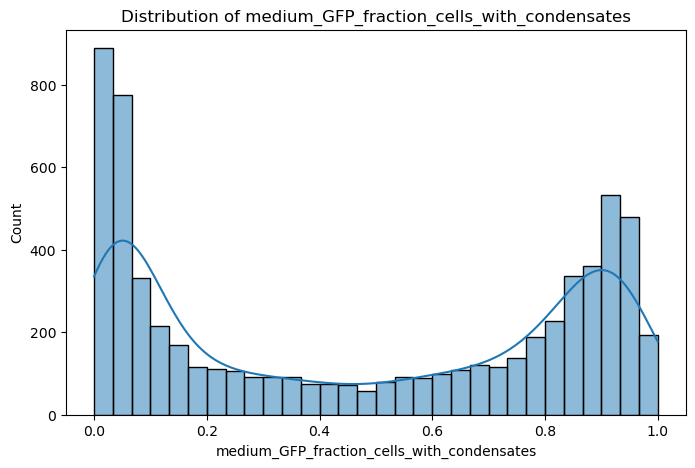

In [83]:
plt.figure(figsize=(8, 5))
sns.histplot(labels, bins=30, kde=True)
plt.xlabel("medium_GFP_fraction_cells_with_condensates")
plt.ylabel("Count")
plt.title("Distribution of medium_GFP_fraction_cells_with_condensates")
plt.show()

### Cluster by Parent Sequence

#### Write seqs to fasta

In [ ]:
import json


### Parent Child Seqs Processing ###
# fasta_id_seq.json -- dictionary matching parent and child fasta id to seq; since protien ids are duplicated, i just used numbers, but fasta_id_seq[parent][1] is not the same as fasta_id_seq[child][1]
# parent_seq.fasta -- fasta of all parent seqs (from poolB... files)
# child_seq.fasta -- fasta of all child seqs (from large_pool_data... )



# i was trying to use protein ids as the fasta headers because i thought they were all unique
# was messier than i expected (320 parent seqs --> 57) after i dropped duplicates (same id mapping to different base / parent sequences)

# for i in range(1, 4):
#     sublib = pd.read_csv(f"/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/poolB_12ntBC_sublibrary{i}.csv")
    
# # sublib1: 314 base
# # sublib2: 306 base
# # sublib3: 307 base
# # 927 total

fasta_id_seq = {"parent":{}, 
                "child": {}}

dfs = [pd.read_csv(f"/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/poolB_12ntBC_sublibrary{i}.csv") for i in range(1, 4)]
base_seqs = (
    pd.concat([df[['protein_id', 'base_protein_seq']] for df in dfs], ignore_index=True)
      .drop_duplicates(keep='first')
      .dropna()
)
# 843 
# 320 after dropna

counts = base_seqs['protein_id'].value_counts()
duplicates = counts[counts > 1]
duplicates, len(duplicates)
# 57 duplicate ids
# I'll just drop the extras

base_seqs = base_seqs.reset_index(drop=True)
base_seqs = base_seqs[~base_seqs['protein_id'].duplicated(keep='first')]

# write parent and child seqs to fasta
output_file = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/parent_seq.fasta"

with open(output_file, "w") as w:
    for i, row in base_seqs.iterrows():
        w.write(f">{i}\n")
        w.write(f"{row['base_protein_seq']}\n")  
        fasta_id_seq['parent'][i] = row['base_protein_seq']

with open("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/child_seqs.fasta", "w") as w:
    for i, row in large_pl_data.iterrows(): 
        w.write(f">{i}\n")
        w.write(f"{row["protein_seq"]}\n")
        fasta_id_seq['child'][i] = row['protein_seq']

with open("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/fasta_id_seq.json", "w") as f:
    json.dump(fasta_id_seq, f)
# # mmseqs createdb ../data/parent_seq.fasta ../data/mmseqs/parent_seq_DB
# # mmseqs search ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_resultDB tmp --min-seq-id 0.8 -c 0.5
# # mmseqs convertalis ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_resultDB  ../data/mmseqs/parent_seq_result.tsv
# # tried with min seq id 0.3 --> same results
 
# hierarchical_cluster_mmseqs("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/parent_seq_result.tsv")





In [323]:
### Write all seqs to one file
# fasta_id_seq.json -- dictionary matching parent and child fasta id to seq; since protien ids are duplicated, i just used numbers, but fasta_id_seq[parent][1] is not the same as fasta_id_seq[child][1]
# all_seqs.fasta -- fasta of all seqs with headers in format >1_p or >1_c ... (p = parent, c = child)



fasta_id_seq = {"parent":{}, 
                "child": {}}

dfs = [pd.read_csv(f"/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/poolB_12ntBC_sublibrary{i}.csv") for i in range(1, 4)]
base_seqs = (
    pd.concat([df[['protein_id', 'base_protein_seq']] for df in dfs], ignore_index=True)
      .drop_duplicates(keep='first')
      .dropna()
)

base_seqs = base_seqs.reset_index(drop=True)
base_seqs = base_seqs[~base_seqs['protein_id'].duplicated(keep='first')]

# write parent and child seqs to fasta
output_file = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/all_seqs.fasta"

with open(output_file, "w") as w:
    for i, row in base_seqs.iterrows():
        w.write(f">{i}_p\n")
        w.write(f"{row['base_protein_seq']}\n")  
        fasta_id_seq['parent'][i] = row['base_protein_seq']

    for i, row in large_pl_data.iterrows(): 
        w.write(f">{i}_c\n")
        w.write(f"{row["protein_seq"]}\n")
        fasta_id_seq['child'][i] = row['protein_seq']

   

In [ ]:
### Hierarchical Clustering ###


# i was trying to use protein ids as the fasta headers because i thought they were all unique
# was messier than i expected (320 parent seqs --> 57) after i dropped duplicates (same id mapping to different base / parent sequences)

# for i in range(1, 4):
#     sublib = pd.read_csv(f"/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/poolB_12ntBC_sublibrary{i}.csv")
    
# # sublib1: 314 base
# # sublib2: 306 base
# # sublib3: 307 base
# # 927 total

# dfs = [pd.read_csv(f"/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/poolB_12ntBC_sublibrary{i}.csv") for i in range(1, 4)]
# base_seqs = (
#     pd.concat([df[['protein_id', 'base_protein_seq']] for df in dfs], ignore_index=True)
#       .drop_duplicates(keep='first')
#       .dropna()
# )
# # 843 
# # 320 after dropna

# counts = base_seqs['protein_id'].value_counts()
# duplicates = counts[counts > 1]
# duplicates, len(duplicates)
# # 57 duplicate ids
# # I'll just drop the extras

# base_seqs = base_seqs.reset_index(drop=True)
# base_seqs = base_seqs[~base_seqs['protein_id'].duplicated(keep='first')]

# # write to fasta
# output_file = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/parent_seq.fasta"

# with open(output_file, "w") as w:
#     for i, row in base_seqs.iterrows():
#         w.write(f">{row['protein_id']}\n")
#         w.write(f"{row['base_protein_seq']}\n")
    
# # mmseqs createdb ../data/parent_seq.fasta ../data/mmseqs/parent_seq_DB
# # mmseqs search ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_resultDB tmp --min-seq-id 0.8 -c 0.5
# # mmseqs convertalis ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_DB ../data/mmseqs/parent_seq_resultDB  ../data/mmseqs/parent_seq_result.tsv
# # tried with min seq id 0.3 --> same results
 
# hierarchical_cluster_mmseqs("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/parent_seq_result.tsv")

# without protein id
dfs = [pd.read_csv(f"/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/poolB_12ntBC_sublibrary{i}.csv") for i in range(1, 4)]

parent_protein_seqs = (
    pd.concat([df[['base_protein_seq', 'protein_seq']] for df in dfs], ignore_index=True)
      .dropna()
)
# 13077 parent sequences

base_seqs = (
    pd.concat([df[['base_protein_seq']] for df in dfs], ignore_index=True)
      .drop_duplicates(keep='first')
      .dropna()
)
# 320 unique parent sequences

output_file = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/parent_seq_1.fasta"
with open(output_file, "w") as w:
    for i, row in base_seqs.iterrows():
        w.write(f">{i}\n")
        w.write(f"{row['base_protein_seq']}\n")

### mmseq code to aln sequences --> similarity scores 
# mmseqs createdb ../data/parent_seq_1.fasta ../data/mmseqs/parent_seq_1_DB
# mmseqs search ../data/mmseqs/parent_seq_1_DB ../data/mmseqs/parent_seq_1_DB ../data/mmseqs/parent_seq__1_resultDB tmp --min-seq-id 0.3 -c 0.5
# mmseqs convertalis ../data/mmseqs/parent_seq_1_DB ../data/mmseqs/parent_seq_1_DB ../data/mmseqs/parent_seq__1_resultDB  ../data/mmseqs/parent_seq__1_result.tsv
# tried with min seq id 0.3 --> same results
# Query identifier 	Target identifier 	Sequence identity 	Alignment length 	Number of mismatches 	Number of gap openings 	Query start position 	Query end position 	Target start position 	Target end position 	E-value 	Bit score


# clusters = hierarchical_cluster_mmseqs("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/parent_seq__1_result.tsv", 
#                                        threshold=0.9, 
#                                        method = "threshold")

# clusters = hierarchical_cluster_mmseqs("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/parent_seq__1_result.tsv", 
#                                        num_clusters=10, 
#                                        method = "num_clusters")

from collections import Counter
Counter([int(i) for i in clusters])


ValueError: invalid literal for int() with base 10: 'Unnamed: 0'

/Users/clairehsieh/miniconda3/envs/esm2/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


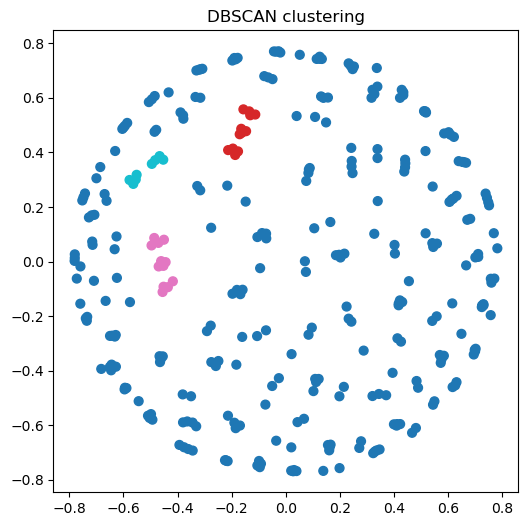

Counter({-1: 288, 0: 12, 1: 12, 2: 8})

In [ ]:
### DBSCAN ###

from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN

dist_matrix = read_mmseqs_into_distance("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/parent_seq__1_result.tsv")
clustering = DBSCAN(eps=0.5, min_samples=5, metric="precomputed")
labels = clustering.fit_predict(dist_matrix)

# Embed into 2D for visualization
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(dist_matrix)

plt.figure(figsize=(6,6))
scatter = plt.scatter(coords[:,0], coords[:,1], c=labels, cmap="tab10", s=40)
plt.title("DBSCAN clustering")
plt.show()

from collections import Counter
Counter([int(i) for i in labels])

In [ ]:
# create groups using parent seqs
# even though the parent seqs are v different, could still have some similarities within base seq mutation groups
# random split of parent seq into groups --> then add in mutated seqs
# since the hierarchical clustering is so uneven, might be better to do random splits?


# random split of parent seqs --> get child seqs and create groups --> logo

import random

# random split -- create dict in format {group : [list of parent seqs], ... }
parent_seqs = list(base_seqs["base_protein_seq"])
random.shuffle(parent_seqs)

k = 10
size = len(parent_seqs) // k
groups = [parent_seqs[i*size:(i+1)*size] for i in range(k-1)]
groups.append(parent_seqs[(k-1)*size:])  
group_to_seq = {i:v for i,v in enumerate(groups)}

# format into X, y, groups for logo split
# groups should be group identity of each element in X (matched by index)
subset_data = large_pl_data.merge(parent_protein_seqs, on="protein_seq")[["protein_seq", "medium_GFP_fraction_cells_with_condensates", "base_protein_seq"]]
subset_data = subset_data.dropna(subset=[subset_data.columns[1]])
seq_data = np.array([one_hot_encode(i) for i in subset_data["protein_seq"]])
labels = subset_data["medium_GFP_fraction_cells_with_condensates"]
# 6409

# reverse group_to_seq dictionary --> {parent_seq1: group, ... } and map group onto child sequences
seq_to_group = {s: g for g, lst in group_to_seq.items() for s in lst}
subset_data["group"] = subset_data["base_protein_seq"].map(seq_to_group).tolist()
subset_data = subset_data.dropna()
groups_list = [seq_to_group[row["base_protein_seq"]] for ind, row in subset_data.iterrows()]

# X = seq_data
# y = labels
# groups = groups_list

### MMSeqs2

In [9]:
# write all seqs to fasta file
large_pl_data = large_pl_data.rename(columns={large_pl_data.columns[0]: "id"})

output_file = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/large_protein.fasta"

with open(output_file, "w") as w:
    for i, row in large_pl_data.iterrows():
        w.write(f">{row['id']}\n")
        w.write(f"{row['protein_seq']}\n")
    

# mmseqs2
# mmseqs easy-cluster /Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/large_protein.fasta clusterRes tmp --min-seq-id 0.5 -c 0.8 --cov-mode 1
# --min-seq-id 0.5 -c 0.8 --cov-mode 1
clusters = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/clusterRes_cluster.tsv", delimiter="\t", header=None, names=["cluster_rep", "member_seq"])
len(set(list(clusters["cluster_rep"]))) 
# 5256 clusters for 14622 sequences

# mmseqs easy-cluster /Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/large_protein.fasta mmseqs/clusterRes_1 mmseqs/tmp --min-seq-id 0.9 -c 0.9 --cov-mode 1
# --min-seq-id 0.9 -c 0.9 --cov-mode 1
clusters = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/clusterRes_1_cluster.tsv", delimiter="\t", header=None, names=["cluster_rep", "member_seq"])
len(set(list(clusters["cluster_rep"]))) 
# 8623

# mmseqs easy-cluster /Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/large_protein.fasta mmseqs/clusterRes_2 mmseqs/tmp --min-seq-id 0.3 -c 0.5 --cov-mode 1
#  --min-seq-id 0.3 -c 0.5 --cov-mode 1
clusters = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/clusterRes_2_cluster.tsv", delimiter="\t", header=None, names=["cluster_rep", "member_seq"])
len(set(list(clusters["cluster_rep"]))) 
# 4729 clusters


4729

/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_46194/4038434663.py:29: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='average')  # or 'single', 'complete', 'ward'


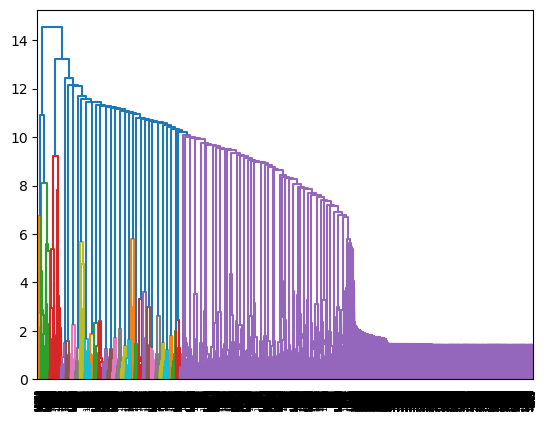

Counter({np.int32(10): 12947,
         np.int32(1): 367,
         np.int32(2): 336,
         np.int32(8): 149,
         np.int32(3): 143,
         np.int32(6): 140,
         np.int32(4): 139,
         np.int32(9): 139,
         np.int32(5): 133,
         np.int32(7): 129})

In [ ]:
# mmseqs --> search --> alignment --> use similarity scores as distance --> hierarchical clustering
# mmseqs createdb ../data/large_protein.fasta ../data/mmseqs/large_prot_DB
# mmseqs search ../data/mmseqs/large_prot_DB ../data/mmseqs/large_prot_DB ../data/mmseqs/resultDB tmp --min-seq-id 0.3 -c 0.5
# mmseqs convertalis ../data/mmseqs/large_prot_DB ../data/mmseqs/large_prot_DB ../data/mmseqs/resultDB  ../data/mmseqs/result.tsv
# result.tsv
# queryID   targetID   sequenceIdentity   alignmentLength   e-value   bitScore

# hierarchical clustering

all_seq_mmseq = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/result.tsv"


clusters = hierarchical_cluster_mmseqs(all_seq_mmseq,
                                       num_clusters=10, 
                                       method = "num_clusters")

Counter([int(i) for i in clusters])

/Users/clairehsieh/miniconda3/envs/esm2/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


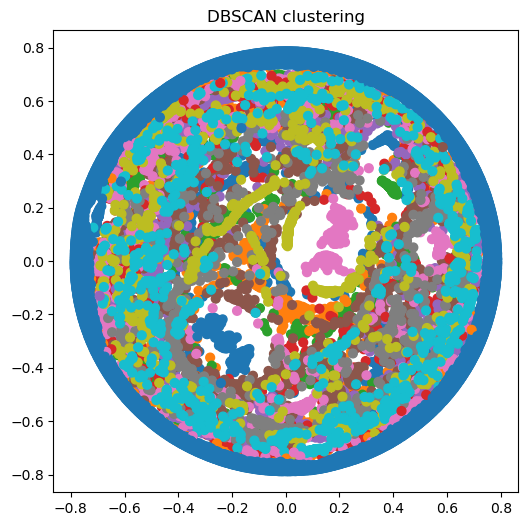

Counter({-1: 5283,
         50: 367,
         2: 337,
         11: 252,
         36: 149,
         18: 143,
         16: 140,
         43: 140,
         1: 139,
         3: 139,
         45: 139,
         6: 138,
         41: 136,
         4: 134,
         21: 134,
         39: 133,
         58: 133,
         62: 132,
         52: 130,
         67: 130,
         32: 128,
         33: 127,
         40: 127,
         57: 127,
         61: 127,
         54: 126,
         42: 125,
         66: 125,
         0: 124,
         10: 124,
         13: 123,
         30: 123,
         17: 121,
         25: 121,
         48: 121,
         72: 121,
         19: 120,
         20: 120,
         56: 120,
         34: 119,
         37: 118,
         46: 118,
         51: 118,
         12: 117,
         53: 117,
         7: 116,
         14: 116,
         28: 116,
         44: 116,
         29: 115,
         24: 114,
         55: 114,
         69: 114,
         5: 112,
         22: 112,
         23: 112,

In [140]:
### DBSCAN ###

from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN

all_seq_mmseq = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/mmseqs/result.tsv"

dist_matrix = read_mmseqs_into_distance(all_seq_mmseq)
clustering = DBSCAN(eps=0.5, min_samples=10, metric="precomputed")
labels = clustering.fit_predict(dist_matrix)

# Embed into 2D for visualization
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(dist_matrix)

plt.figure(figsize=(6,6))
scatter = plt.scatter(coords[:,0], coords[:,1], c=labels, cmap="tab10", s=40)
plt.title("DBSCAN clustering")
plt.show()

from collections import Counter
Counter([int(i) for i in labels])

### ESM2 embeddings

In [24]:
label = "medium_GFP_fraction_cells_with_condensates"
esm_emb_dir = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/esm/all/"
fasta_file = "/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/all_seqs.fasta"
large_pl_data = pd.read_csv("/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/data/large_pool_data_with_seq_info_202507.csv") 
fasta_id_seq = {"parent":{}, 
                "child": {}}
balanced_splits = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/model/kappel-lab-condensate-pred/simple_models/train_test_val_split_evaluation/9_19_25_base_split/codenSeq_data_with_base_split.csv")

dfs = [pd.read_csv(f"/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/poolB_12ntBC_sublibrary{i}.csv") for i in range(1, 4)]
base_seqs = (
    pd.concat([df[['protein_id', 'base_protein_seq']] for df in dfs], ignore_index=True)
      .drop_duplicates(keep='first')
      .dropna()
)

/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_2247/1976639383.py:4: DtypeWarning: Columns (6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  large_pl_data = pd.read_csv("/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/data/large_pool_data_with_seq_info_202507.csv")
/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_2247/1976639383.py:7: DtypeWarning: Columns (6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  balanced_splits = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/model/kappel-lab-condensate-pred/simple_models/train_test_val_split_evaluation/9_19_25_base_split/codenSeq_data_with_base_split.csv")


In [ ]:
# map protein seq, ids, esm_embeddings, labels, splits
def read_fasta_to_dict(filepath):
    fasta_dict = {}
    with open(filepath, 'r') as f:
        header = None
        seq_chunks = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                if header:
                    fasta_dict[header] = ''.join(seq_chunks)
                header = line[1:].split()[0]  # take header up to first space
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header:
            fasta_dict[header] = ''.join(seq_chunks)
    return fasta_dict

id_to_seq = read_fasta_to_dict(fasta_file)
splits = dict(zip(balanced_splits['protein_seq'], balanced_splits['base_split']))
id_to_split = {id_to_seq[k]:splits[v] for k,v in id_to_seq.items()}
seq_to_label = dict(zip(balanced_splits['protein_seq'], balanced_splits[label]))
id_to_label = {k:seq_to_label[v] for k,v in id_to_seq.items()}

# for file in os.listdir(esm_emb_dir):
#     embedding = torch.load(f"{esm_emb_dir}/{file}"")



{'0_p': 0.0808923870100217,
 '1_p': 0.0239565989565989,
 '2_p': 0.3063704579527364,
 '5_p': 0.1809947299077733,
 '6_p': nan,
 '7_p': 0.0187055281882868,
 '8_p': 0.6153846153846154,
 '9_p': nan,
 '10_p': 0.8008524646463276,
 '12_p': 0.8961038961038961,
 '13_p': nan,
 '14_p': 0.0730115361262902,
 '15_p': 0.9002788575931863,
 '16_p': 0.9039552736982644,
 '17_p': 0.3346170774647887,
 '18_p': 0.4524970280384997,
 '19_p': 0.3846153846153846,
 '20_p': 0.8305084745762712,
 '21_p': nan,
 '22_p': 0.6255971144044539,
 '24_p': nan,
 '27_p': 0.937824617995372,
 '28_p': nan,
 '29_p': 0.0259928574764848,
 '31_p': 0.9551920341394028,
 '33_p': 0.9428921568627452,
 '34_p': nan,
 '35_p': nan,
 '36_p': 0.8793103448275862,
 '37_p': 0.0449699289229086,
 '44_p': nan,
 '45_p': 0.3928571428571428,
 '47_p': 0.1263997994317232,
 '48_p': 0.8157894736842105,
 '49_p': 0.0487326437424284,
 '51_p': nan,
 '53_p': 0.7041282532430448,
 '54_p': nan,
 '56_p': 0.2148712902241128,
 '57_p': 0.0185185185185185,
 '59_p': 0.069

### Train Test Split - Mia


In [ ]:
### Read in Train Test Split Mia ###
# format: dict with protein_seq as id - match to group, label, x (features, one hot, or kmer table)
label = "medium_GFP_fraction_cells_with_condensates"
clusters = pd.read_csv('/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/data/parent_child_clusters.csv')
cluster_ids = [int(k) for k, v in Counter(clusters["cluster_id"].values).items() if v > 2]
clusters = clusters[clusters['cluster_id'].isin(cluster_ids)]

model_input = {row["protein_seq"]:{"group":0, "x":one_hot_encode(row["protein_seq"]), "y":row[label]} for i,row in large_pl_data.dropna(subset=["medium_GFP_fraction_cells_with_condensates"]).iterrows()}
for i, row in clusters.iterrows():
    try:        model_input[row["protein_seq"]]["group"] = row["cluster_id"]
    except:     pass
model_input


### Train Test Split Balanced - Elena

In [6]:
label = "medium_GFP_fraction_cells_with_condensates"

balanced_splits = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/model/kappel-lab-condensate-pred/simple_models/train_test_val_split_evaluation/9_19_25_base_split/codenSeq_data_with_base_split.csv")
balanced_splits = balanced_splits.dropna(subset=[label])
train = balanced_splits.loc[balanced_splits["base_split"] == "train"]
test = balanced_splits.loc[balanced_splits["base_split"] == "test"]
val = balanced_splits.loc[balanced_splits["base_split"] == "val"]

model_input = {"train":{'x':0, 'y':0}, 
               "test":{'x':0, 'y':0}, 
               "val":{'x':0, 'y':0}}
for k, df in zip(model_input.keys(), [train, test, val]):
    model_input[k]["x"] = np.array([one_hot_encode(row['protein_seq']) for i,row in df.iterrows()])
    model_input[k]["x"] = np.array([row[label] for i, row in df.iterrows()])
    model_input[k]["seqs"] = [row['protein_seq'] for i,row in df.iterrows()]


/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_7777/185918039.py:3: DtypeWarning: Columns (6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  balanced_splits = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/model/kappel-lab-condensate-pred/simple_models/train_test_val_split_evaluation/9_19_25_base_split/codenSeq_data_with_base_split.csv")


## Model

### MLP

In [10]:

class Config:
    def __init__(self,
                 output_dir,
                 seed=0,
                 num_folds=5,
                 max_epochs=100,
                 lr=0.001,
                 batch_size=10,
                 input_dim=100,
                 hidden_dim=512,
                 output_dim=1,
                 num_epochs=500,
                 num_layers=3,
                 verbose=False,
                 layernorm=False,
                 dropout=False,
                 dropout_rate=0.05, 
                 early_stopping=True,
                 patience = 30,
                 delta = 0.05, 
                 train_split = "kfold", 
                 criterion = "regression"):       
        self.layernorm = layernorm
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        if torch.cuda.is_available():            self.device = torch.device("cuda")
        elif torch.backends.mps.is_available():  self.device = torch.device("mps")
        else:                                    self.device = torch.device("cpu")
        print("Using device:", self.device)    
            
        # training parameters
        self.seed = seed
        self.num_folds = num_folds
        self.max_epochs = max_epochs
        self.lr = lr
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.verbose = verbose
        self.early_stopping = early_stopping
        self.patience = patience    
        self.delta = delta
        self.output_dir = f"{output_dir}/seed_{seed}/lr_{lr}/hidden_dim_{hidden_dim}/num_layers_{num_layers}/batch_size_{batch_size}/"
        self.train_split = train_split
        self.criterion = criterion
        if not os.path.exists(self.output_dir): os.makedirs(self.output_dir)
        if dropout: self.output_dir += f"dropout_{dropout_rate}/"
        if layernorm: self.output_dir += f"layernorm/"
        if early_stopping: self.output_dir += f"early_stopping_patience_{patience}_delta_{delta}/"

    def __str__(self):
        return '\n'.join(f'{k}: {v}' for k, v in vars(self).items())

    def __repr__(self):
        return self.__str__()

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_dim = config.hidden_dim
        self.num_layers = config.num_layers
        self.input_dim = config.input_dim
        
        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim , self.hidden_dim),
            nn.LeakyReLU()
        ).to(config.device)
        
        # final layer always outputs 1 value per sample
        self.final = nn.Linear(self.hidden_dim, 1).to(config.device)
        
        self.layer_norm = nn.LayerNorm(self.hidden_dim).to(config.device)
        self.logZ = nn.Parameter(torch.ones(1, device=config.device))

    def forward(self, x):
        output = self.mlp(x)        # [batch_size, hidden_dim]
        output = self.final(output) # [batch_size, 1]
        return output.squeeze(-1)   # [batch_size]

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

# data: (6994, 66, 20)
#       (batch, seq_len, amino acid)
# linearize: (6994, 1320)


In [11]:

class CondensateDataset(Dataset):
    def __init__(self, x, y):
        # x: 2D array-like [n_samples, n_features]
        # y: 1D array-like [n_samples]
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

#### UTILS ##### 
class EarlyStopping:
    def __init__(self, patience=15, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

def log_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

def mean(ls):
    return sum(ls) / len(ls)

def compute_spearman_correlation(actuals, predictions):
    try:
        if np.all(actuals == actuals[0]) or np.all(predictions == predictions[0]):
            print("Warning: Constant array detected - correlation undefined")
            return 0          
        correlation, _ = spearmanr(actuals, predictions)
        return correlation
    except Exception as e:
        print(f"Error computing correlation: {e}")
        return None

def compute_pearson_correlation(actuals, predictions):
    if isinstance(actuals, torch.Tensor):
        actuals = actuals.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    correlation, _ = pearsonr(actuals, predictions)
    return correlation

def plot_epoch_losses(epoch_train_losses, epoch_val_losses, filename, output_dir):
    print(f"Train Losses: {epoch_train_losses}")
    print(f"Val Losses: {epoch_val_losses}")
    plt.figure()
    plt.plot(epoch_train_losses, label='Training Loss')
    plt.plot(epoch_val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss | Fold {filename}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(output_dir + f"Fold{filename}_loss_plot.jpg")
    plt.close()

def plot_fold_scatter(val_actual, val_pred, train_actual, train_pred, correlations, fold, output_dir):   
    # Plot scatterplot for validation data
    plt.figure(figsize=(8, 6))
    plt.scatter(val_actual, val_pred, alpha=0.6, label="Validation Data", color="orange")
    plt.plot([min(val_actual), max(val_actual)], [min(val_actual), max(val_actual)], 'r--', label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Validation Data: Actual vs Predicted")
    plt.legend()
    # Add correlations as text on the validation plot
    plt.text(
        0.95, 0.05,
        f"Spearman: {correlations['val_spearman']:.2f}\nPearson: {correlations['val_pearson']:.2f}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )
    plt.savefig(os.path.join(output_dir, f"validation_fold_{fold}.png"))
    plt.close()

    # Plot scatterplot for training data
    plt.figure(figsize=(8, 6))
    plt.scatter(train_actual, train_pred, alpha=0.6, label="Training Data", color="blue")
    plt.plot([min(train_actual), max(train_actual)], [min(train_actual), max(train_actual)], 'r--', label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Training Data: Actual vs Predicted")
    plt.legend()
     # Add correlations as text on the training plot
    plt.text(
        0.95, 0.05,
        f"Spearman: {correlations['train_spearman']:.2f}\nPearson: {correlations['train_pearson']:.2f}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )
    plt.savefig(os.path.join(output_dir, f"training_fold_{fold}.jpg"))
    plt.close()

def plot_all_folds_losses(losses, output_dir, filename="all_folds"):
    """
    losses: dict with keys 'train_losses' and 'val_losses'
            values are lists of lists, one list per fold
            e.g. losses['train_losses'][i] = list of training losses for fold i
    output_dir: directory to save plot
    filename: filename prefix for saved plot
    """
    train_folds = losses["train_losses"]
    val_folds = losses["val_losses"]

    n_folds = len(train_folds)
    fig, axes = plt.subplots(1, n_folds, figsize=(5 * n_folds, 4), sharey=True)

    if n_folds == 1:  # make axes iterable if only one subplot
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.plot(train_folds[i], label="Training Loss")
        ax.plot(val_folds[i], label="Validation Loss")
        ax.set_title(f"Fold {i+1}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()

    plt.tight_layout()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, f"{filename}_loss_plot.jpg"))
    plt.close()

def plot_all_folds_scatter(fold_outputs, all_correlations, output_dir, filename="all_folds_scatter"):
    """
    fold_outputs: dict with keys
        'fold_train_actual', 'fold_train_pred',
        'fold_val_actual', 'fold_val_pred'
        Each is a list of lists (one per fold).

    all_correlations: list of dicts (one per fold), each dict has keys
        'train_spearman', 'val_spearman', 'train_pearson', 'val_pearson'

    output_dir: directory to save the figure
    filename: filename prefix for saved plot
    """

    n_folds = len(fold_outputs["fold_train_actual"])
    fig, axes = plt.subplots(2, n_folds, figsize=(5 * n_folds, 10), sharey=True)

    if n_folds == 1:  # axes will be 1D
        axes = axes[:, None]  # make it 2x1 array

    for i in range(n_folds):
        # Training subplot (top row)
        ax_train = axes[0, i]
        train_actual = fold_outputs["fold_train_actual"][i]
        train_pred = fold_outputs["fold_train_pred"][i]
        ax_train.scatter(train_actual, train_pred, alpha=0.6, color="blue", label="Training")
        ax_train.plot([min(train_actual), max(train_actual)],
                      [min(train_actual), max(train_actual)],
                      'r--', label="Ideal Fit")
        ax_train.set_xlabel("Actual Values")
        ax_train.set_ylabel("Predicted Values")
        ax_train.set_title(f"Fold {i+1} Training")
        ax_train.legend()
        # Correlation text
        corr_val = all_correlations[i]
        ax_train.text(
            0.95, 0.05,
            f"Spearman: {corr_val['train_spearman']:.2f}\nPearson: {corr_val['train_pearson']:.2f}",
            transform=ax_train.transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
        )

        # Validation subplot (bottom row)
        ax_val = axes[1, i]
        val_actual = fold_outputs["fold_val_actual"][i]
        val_pred = fold_outputs["fold_val_pred"][i]
        ax_val.scatter(val_actual, val_pred, alpha=0.6, color="orange", label="Validation")
        ax_val.plot([min(val_actual), max(val_actual)],
                    [min(val_actual), max(val_actual)],
                    'r--', label="Ideal Fit")
        ax_val.set_xlabel("Actual Values")
        ax_val.set_ylabel("Predicted Values")
        ax_val.set_title(f"Fold {i+1} Validation")
        ax_val.legend()
        # Correlation text
        ax_val.text(
            0.95, 0.05,
            f"Spearman: {corr_val['val_spearman']:.2f}\nPearson: {corr_val['val_pearson']:.2f}",
            transform=ax_val.transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
        )

    plt.tight_layout()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, f"{filename}.png"))
    plt.close()

def get_accuracy_f1(actuals_val, preds_val, actuals_train, preds_train):
    # Compute accuracy and F1 score
    train_accuracy = accuracy_score(actuals_train, preds_train)
    val_accuracy = accuracy_score(actuals_val, preds_val)
    train_f1 = f1_score(actuals_train, preds_train, average='weighted')
    val_f1 = f1_score(actuals_val, preds_val, average='weighted')
    return train_accuracy, val_accuracy, train_f1, val_f1

def get_baseline_accuracy(actuals_val, actuals_train):
    majority_class = np.argmax(np.bincount(actuals_train))
    baseline_accuracy_train = np.mean(actuals_train == majority_class)
    majority_class = np.argmax(np.bincount(actuals_val))
    baseline_accuracy_val = np.mean(actuals_val == majority_class)
    return baseline_accuracy_train, baseline_accuracy_val

def plot_confusion_matrix(fold_outputs, config, name=None):
    n_folds = len(fold_outputs["fold_train_actual"])
    
    # total subplots: 2 per fold (train + validation)
    fig, axes = plt.subplots(n_folds, 2, figsize=(14, 6 * n_folds))

    for fold in range(n_folds):
        actuals_val = fold_outputs["fold_val_actual"][fold]
        preds_val = fold_outputs["fold_val_pred"][fold]
        actuals_train = fold_outputs["fold_train_actual"][fold]
        preds_train = fold_outputs["fold_train_pred"][fold]

        spearman_train = compute_spearman_correlation(actuals_train, preds_train)
        spearman_val   = compute_spearman_correlation(actuals_val, preds_val)

        cm_train = confusion_matrix(actuals_train, preds_train)
        cm_val   = confusion_matrix(actuals_val, preds_val)

        baseline_accuracy_train, baseline_accuracy_val = get_baseline_accuracy(actuals_val, actuals_train)
        train_accuracy, val_accuracy, train_f1, val_f1 = get_accuracy_f1(actuals_val, preds_val, actuals_train, preds_train)

        # Train confusion matrix subplot
        ax_train = axes[fold, 0] if n_folds > 1 else axes[0]
        sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12}, ax=ax_train)
        title_train = (
            f'Confusion Matrix - Training Data (Fold {fold})\n'
            f'Acc: {train_accuracy:.2f}, F1: {train_f1:.2f}, Baseline: {baseline_accuracy_train:.2f}, '
            f'Spearman: {spearman_train:.2f}'
        )
        if name: title_train += f"\n{name}"
        ax_train.set_title(title_train, fontsize=14)
        ax_train.set_xlabel('Predicted', fontsize=12)
        ax_train.set_ylabel('Actual', fontsize=12)

        # Validation confusion matrix subplot
        ax_val = axes[fold, 1] if n_folds > 1 else axes[1]
        sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12}, ax=ax_val)
        title_val = (
            f'Confusion Matrix - Validation Data (Fold {fold})\n'
            f'Acc: {val_accuracy:.2f}, F1: {val_f1:.2f}, Baseline: {baseline_accuracy_val:.2f}, '
            f'Spearman: {spearman_val:.2f}'
        )
        if name: title_val += f"\n{name}"
        ax_val.set_title(title_val, fontsize=14)
        ax_val.set_xlabel('Predicted', fontsize=12)
        ax_val.set_ylabel('Actual', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(config.output_dir, f'confusion_matrices_all_folds.png'))
    plt.close()

def get_predictions(model, dataloader, config):
    model.eval()
    all_actuals = []
    all_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            x,y = batch
            output = model(x)
            if config.criterion == "classification": 
                output = (torch.sigmoid(torch.tensor(output)) >= 0.5).int() #logits --> probabilities --> class]
            all_actuals.extend(y.cpu().numpy())
            all_predictions.extend(output.cpu().numpy())
    all_actuals = np.array(all_actuals)
    all_predictions = np.array(all_predictions)
    return all_actuals, all_predictions

def plot_prediction_results(actual, predicted, filename = None):
    plt.scatter(actual, predicted)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title("Actual vs Predicted")
    plt.show()
    if filename: plt.savefig(filename)

def train(X, y, config, groups=None):    
    dataset = CondensateDataset(X, y)

    output_dir = config.output_dir
    fold_outputs = {"fold_train_actual":[], 
                    "fold_train_pred":[],
                     "fold_val_actual":[], 
                     "fold_val_pred":[]}
    logs = {"fold_actuals":[],
            "fold_preds":[],
            "fold_train_actuals":[],
            "fold_train_preds":[],
            "fold_train_losses":[],
            "fold_val_losses":[],
            "train_num_genes":[],
            "all_train_labels":[],
            "val_num_genes":[],
            "all_val_labels":[],
            "f1_accuracy":{},
            "all_correlation":[]}
    if config.criterion == "regression":     loss_fn = nn.MSELoss()
    elif config.criterion == "classification": loss_fn = nn.CrossEntropyLoss()
    else: print("config.criterion should be 'regression' or 'classification'")

    training_logs = {"train_actual" : [],
                    "train_pred" : [],
                    "val_actual" : [],
                    "val_pred" : [],
                    "epoch_train_losses" : [],
                    "epoch_val_losses" : []}
    model_output_dir = output_dir + "/model/"
    if not os.path.exists(model_output_dir): os.makedirs(model_output_dir)

    losses = {"train_losses":[], "val_losses":[]}
    all_correlations = []
    #### Training loop ##### 

    #  Train test split
    if config.train_split == "kfold":
        print("Train test split with kfold cross validation")
        splitter = KFold(n_splits=5, shuffle=True, random_state=config.random_seed)
        splits = splitter.split(range(len(dataset)))
    else:
        print("Train test split with leave one group out")
        splitter = LeaveOneGroupOut()
        splits = splitter.split(X, y, groups)

    for fold, (train_idx, val_idx) in enumerate(splits):
        # internals written once
        print(f"Fold {fold}, train size={len(train_idx)}, val size={len(val_idx)}")
        model = MLP(config)
        train_dataloader = DataLoader(Subset(dataset, train_idx), batch_size=config.batch_size, shuffle=True, num_workers=0)
        val_dataloader = DataLoader(Subset(dataset, val_idx), batch_size=config.batch_size, shuffle=False, num_workers=0)
        epoch_train_losses = []
        epoch_val_losses = []
        val_labels = []
        # for fold in range(num_folds):
        filename = fold
        optimizer = optim.Adam(model.parameters(), lr=config.lr)
        if config.early_stopping:
            early_stopping =  EarlyStopping(patience=config.patience, delta=config.delta)
        print(f'Fold {fold+1}/{config.num_folds}')
        log_memory_usage()

        for epoch in tqdm(range(config.max_epochs)):
            model.train()
            train_losses = []
            val_losses = []
            for batch in train_dataloader:
                x, y = batch
                x = x.to(config.device)
                y = y.to(config.device)
                optimizer.zero_grad()
                device = next(model.parameters()).device  
                output = model(x)
                output.requires_grad_(True)  
                loss = loss_fn(output.float(), y.float())
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
            model.eval()
            with torch.no_grad():
                for batch in val_dataloader:
                    x, y = batch
                    x = x.to(config.device)
                    y = y.to(config.device)
                    output = model(x)
                    loss = loss_fn(output.float(), y.float())                
                    val_losses.append(loss.item())
                epoch_train_losses.append(mean(train_losses))
                epoch_val_losses.append(mean(val_losses))
                if config.early_stopping:
                    early_stopping(mean(val_losses), model)
                    if early_stopping.early_stop:
                        print(f"Early stopping at epoch {epoch}")
                        early_stopping.load_best_model(model)
                        break
        
        logs["all_val_labels"].append(val_labels)
        logs["fold_train_losses"].append(epoch_train_losses)
        logs["fold_val_losses"].append(epoch_val_losses)
        train_actual, train_pred = get_predictions(model, train_dataloader, config)
        val_actual, val_pred = get_predictions(model, val_dataloader, config)
        logs["fold_actuals"].append(val_actual)
        logs["fold_preds"].append(val_pred)
        logs["fold_train_actuals"].append(train_actual)
        logs["fold_train_preds"].append(train_pred)
        if config.criterion == "regression": 
            correlations = {
                "train_spearman": compute_spearman_correlation(train_actual, train_pred) or 0,
                "val_spearman": compute_spearman_correlation(val_actual, val_pred) or 0,
                "train_pearson": compute_pearson_correlation(train_actual, train_pred) or 0,
                "val_pearson": compute_pearson_correlation(val_actual, val_pred) or 0
            }
            all_correlations.append(correlations)
        logs["all_correlation"].append(correlations)
        # plot_epoch_losses(epoch_train_losses, epoch_val_losses, filename, output_dir)
        # plot_fold_scatter(val_actual, val_pred, train_actual, train_pred, correlations, fold, output_dir)        

        losses["train_losses"].append(epoch_train_losses), losses["val_losses"].append(epoch_val_losses)
        fold_outputs["fold_train_actual"].append(train_actual), fold_outputs["fold_train_pred"].append(train_pred), fold_outputs["fold_val_actual"].append(val_actual), fold_outputs["fold_val_pred"].append(val_pred), 
        log_memory_usage()
        torch.save(model.state_dict(), os.path.join(model_output_dir, f"model_fold_{fold}.pth"))
        # plot_correlations(logs["all_correlation"], output_dir)

    # Save logs and fold_outputs as pkl
    plot_all_folds_losses(losses, output_dir, filename="all_folds")
    if config.criterion == "regression":     plot_all_folds_scatter(fold_outputs, all_correlations, output_dir, filename="all_folds_scatter")
    elif config.criterion == "classification": plot_confusion_matrix(fold_outputs, config, name=None)

    logs_file = os.path.join(output_dir, "logs.pkl")
    with open(logs_file, "wb") as f:
        pickle.dump(logs, f)
    print(f"Logs outputs saved to {logs_file}")
    fold_outputs_file = os.path.join(output_dir, "fold_outputs.pkl")
    with open(fold_outputs_file, "wb") as f:
        pickle.dump(fold_outputs, f)
    print(f"Fold outputs saved to {fold_outputs_file}")

    return model, logs, fold_outputs, losses


In [12]:
# regression task

config = Config(output_dir = "/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/results/logo/",
                batch_size=10, input_dim=1320, output_dim=1, train_split="logo")

seq_data = torch.tensor(seq_data.reshape(seq_data.shape[0], -1), dtype=torch.float32).to(config.device)
labels   = torch.tensor(labels, dtype=torch.float32).to(config.device)

model = MLP(config)
model, logs, fold_outputs, losses = train(seq_data, labels, config, groups=groups_list)


Using device: mps


NameError: name 'seq_data' is not defined

In [ ]:
# classification task

config = Config(output_dir = "/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/results/logo/classification/",
                batch_size=10, input_dim=1320, output_dim=1, train_split="logo", criterion="classification")

seq_data = torch.tensor(seq_data.reshape(seq_data.shape[0], -1), dtype=torch.float32).to(config.device)
labels = (torch.tensor(labels, dtype=torch.float32) >= 0.5).int().to(config.device) # for classification

model, logs, fold_outputs, losses = train(seq_data, labels, config, groups=groups_list)


In [ ]:
# run with kmer table as input
# k, num unique seqs
# 3,7530
# 4,67629
# 5,152393
# 6,184864
# 7,197550
# 8,205787
# 9,212356

seqs = subset_data["protein_seq"].values
kmer_matrix, unique_kmers = kmer_table(seqs, k=3)
labels = (torch.tensor(labels, dtype=torch.float32) >= 0.5).int().to(config.device) # for classification
kmer_matrix = torch.tensor(kmer_matrix, dtype=torch.float32).to(config.device)


config = Config(output_dir = "/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/results/logo/classification/kmer/",
                batch_size=10, input_dim=7530, output_dim=1, train_split="logo", criterion="classification")

model = MLP(config)

# model, logs, fold_outputs, losses = train(kmer_matrix, labels, config, groups=groups_list)


Using device: mps


/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_39334/937504132.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = (torch.tensor(labels, dtype=torch.float32) >= 0.5).int().to(config.device) # for classification


In [ ]:
### one hot input, parent child grouping split
x = torch.tensor([i["x"] for i in model_input.values()], dtype=torch.float32).to(config.device)
x = x.reshape(x.shape[0], -1)
y = torch.tensor([i["y"] for i in model_input.values()], dtype=torch.float32).to(config.device)
group = [i["group"] for i in model_input.values()]


config = Config(output_dir = "/Users/clairehsieh/OneDrive/Documents/UCLA/rotations/kalli_kappel/results/logo/classification//",
                batch_size=10, input_dim=1320, output_dim=1, train_split="logo", criterion="classification")

# model, logs, fold_outputs, losses = train(x, y, config, groups=group)

Using device: mps


### Linear Model

In [316]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    # round + cast to int in case predictions are floats
    y_true = np.rint(np.array(y_true)).astype(int)
    y_pred = np.rint(np.array(y_pred)).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # accuracy
    acc = accuracy_score(y_true, y_pred)

    # baseline accuracy = majority class frequency
    majority_class = np.argmax(np.bincount(y_true))
    baseline_acc = np.mean(y_true == majority_class)

    # plot
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title}\nAcc: {acc:.2f}, Baseline: {baseline_acc:.2f}")
    plt.tight_layout()
    plt.show()


/var/folders/sq/z_zb6snx1n95mjp1hndhb_km0000gn/T/ipykernel_39334/2822648684.py:1: DtypeWarning: Columns (6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  balanced_splits = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/model/kappel-lab-condensate-pred/simple_models/train_test_val_split_evaluation/9_19_25_base_split/codenSeq_data_with_base_split.csv")


Coefficient: [-0.03942719 -0.04145074 -0.07002908 ...  0.00394569  0.2770118
 -0.01892404]
Intercept: 0.9475062


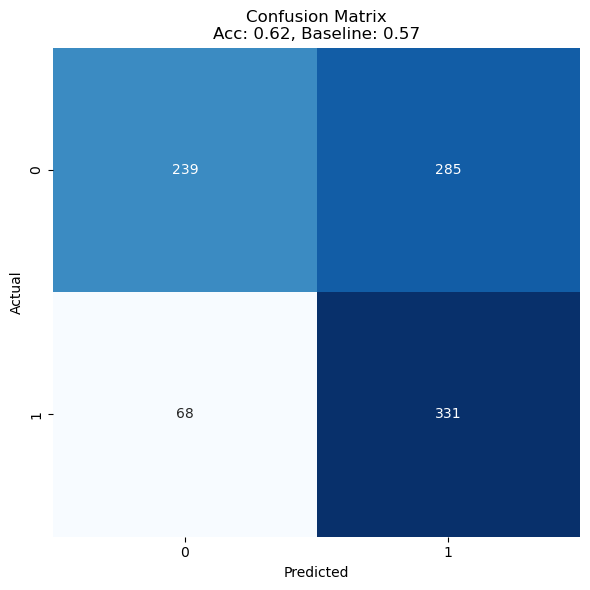

MSE: 0.2369278371334076


In [ ]:
### one hot seq on balanced splits

balanced_splits = pd.read_csv("/Users/clairehsieh/Library/CloudStorage/OneDrive-Personal/Documents/UCLA/rotations/kalli_kappel/model/kappel-lab-condensate-pred/simple_models/train_test_val_split_evaluation/9_19_25_base_split/codenSeq_data_with_base_split.csv")
balanced_splits = balanced_splits.dropna(subset=[label])

train = balanced_splits.loc[balanced_splits["base_split"] == "train"]
test = balanced_splits.loc[balanced_splits["base_split"] == "test"]
val = balanced_splits.loc[balanced_splits["base_split"] == "val"]



model_input = {"train":{'x':0, 'y':0}, 
            "test":{'x':0, 'y':0}, 
            "val":{'x':0, 'y':0}}
for k, df in zip(model_input.keys(), [train, test, val]):
    model_input[k]['x'] = np.array([one_hot_encode(row['protein_seq']) for i,row in df.iterrows()])
    model_input[k]['x'] = torch.tensor(model_input[k]['x'].reshape(model_input[k]['x'].shape[0], -1), dtype=torch.float32).to(config.device)
    model_input[k]['y'] = (torch.tensor(np.array([row[label] for i, row in df.iterrows()]), dtype=torch.float32) >= 0.3).int().to(config.device)

train_x = torch.cat([model_input["train"]["x"].cpu(), model_input["val"]["x"].cpu()], dim=0).numpy()
train_y = torch.cat([model_input["train"]["y"].cpu(), model_input["val"]["y"].cpu()], dim=0).numpy()
test_x = model_input["test"]["x"].cpu().numpy()
test_y = model_input["test"]["y"].cpu().numpy()


model = LinearRegression()
model.fit(train_x, train_y)
print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)
y_pred = model.predict(test_x)
plot_confusion(test_y, np.array(y_pred >= 0.3).astype(int))
mse = mean_squared_error(test_y, y_pred)
print("MSE:", mse)


Coefficient: [-0.06106421 -0.50465924 -0.2805002  ...  0.5990426   0.39052597
 -0.05124221]
Intercept: 0.93636656


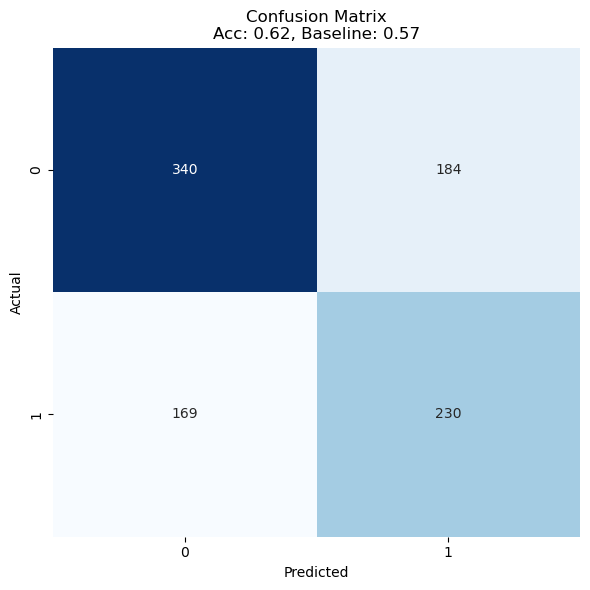

MSE: 4.0372843742370605


In [317]:
### kmer table

kmer_matrix, unique_kmers = kmer_table(list(balanced_splits["protein_seq"]), k=3)

model_input = {"train":{'x':0, 'y':0}, 
            "test":{'x':0, 'y':0}, 
            "val":{'x':0, 'y':0}}
for k, df, n in zip(model_input.keys(), [train, test, val], ["train", "test", "val"]):
    model_input[k]['y'] = (torch.tensor(np.array([row[label] for i, row in df.iterrows()]), dtype=torch.float32) >= 0.3).int().to(config.device)
    model_input[k]['x'] = torch.tensor(kmer_matrix[balanced_splits["base_split"] == n], dtype=torch.float32).to(config.device)


train_x = torch.cat([model_input["train"]["x"].cpu(), model_input["val"]["x"].cpu()], dim=0).numpy()
train_y = torch.cat([model_input["train"]["y"].cpu(), model_input["val"]["y"].cpu()], dim=0).numpy()
test_x = model_input["test"]["x"].cpu().numpy()
test_y = model_input["test"]["y"].cpu().numpy()

model = LinearRegression()
model.fit(train_x, train_y)
print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)
y_pred = model.predict(test_x)
plot_confusion(test_y, np.array(y_pred >= 0.3).astype(int))
mse = mean_squared_error(test_y, y_pred)
print("MSE:", mse)



# Notes
- First, a set of 79 “base sequences” was selected for extensive
mutagenesis. These sequences include 43 of the fragments of natural protein sequences
and one designed variant from the small sequence library, for a total of 44 “Class 1 base
sequences.” Another 35 fragments of natural protein sequences (“Class 2 base
sequences”) were further selected from PhasePro, excluding protein sequences that were
annotated as partner dependent. To this end, all protein regions annotated to drive phase
separation were examined, and all possible 66 amino acid fragments with amino acid
composition and dipeptide composition similarity (Pearson correlation coefficient (r2)) to
the Class 1 base sequences and to each other of less than 0.6 (“Class 3 sequences”)
were identified. 35 of these sequences, including at most one sequence fragment per
protein and prioritizing sequence fragments with the highest amino acid composition
similarity to the full protein region as well as regions that were predicted to be more
disordered.

- The natural protein sequence fragment set includes: (1) all base sequences, (2) all
remaining Class 3 sequences (283 sequences), (3) Class 4A sequences (519
sequences): fragments from disordered (as annotated by MobiDB36) sequences from
LLPSDB37 that were annotated either as phase separating or not phase separating with
maximum amino acid composition and dipeptide correlation of 0.8 to each other and to
all base sequences and all Class 3 sequences; and (4) Class 4B sequences (798
sequences): disordered regions (as annotated by MobiDB) from Disprot38 (release
2022_03) with maximum amino acid composition and dipeptide correlation of 0.6 to each
other and to all base sequences, Class 3 sequences, and Class 4A sequences.